# Overfitting & regularization methods


In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import miowad.nn as nn
from miowad.data import RegressionDataset, ClassificationDataset
from miowad.data import MinMaxScaler, StandardScaler, OneHotEncoder
from miowad.nn.viz import visualize_nn
from miowad.utils import set_seed

set_seed(123)

In [3]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_classification(model, X_train, y_train, X_test, y_test, softmax=True):

    preds_train = model.forward(X_train)
    preds_test = model.forward(X_test)

    if softmax:
        preds_train = nn.softmax(preds_train)
        preds_test = nn.softmax(preds_test)

    preds_train = preds_train.argmax(axis=1)
    preds_test = preds_test.argmax(axis=1)

    print("Training accuracy: {:.2f}".format(accuracy_score(y_train, preds_train)))
    print("Test accuracy: {:.2f}".format(accuracy_score(y_test, preds_test,)))
    print("-"*10)
    print("Training F1-score: {:.2f}".format(f1_score(y_train, preds_train, average='macro')))
    print("Test F1-score: {:.2f}".format(f1_score(y_test, preds_test, average='macro')))

In [4]:
from miowad.metrics import mean_squared_error

def evaluate_regression(model, X_train, y_train, X_test, y_test, X_scaler, y_scaler):

    preds_train = model.forward(X_train)
    preds_test = model.forward(X_test)

    # unnormalize predictions
    if y_scaler is not None:
        preds_train = y_scaler.inverse_transform(preds_train)
        preds_test = y_scaler.inverse_transform(preds_test)

    # unnormalize data
    if X_scaler is not None and y_scaler is not None:
        X_train = X_scaler.inverse_transform(X_train)
        X_test = X_scaler.inverse_transform(X_test)
        y_train = y_scaler.inverse_transform(y_train)
        y_test = y_scaler.inverse_transform(y_test)

    print("Training MSE: {:.2f}".format(mean_squared_error(y_train, preds_train)))
    print("Test MSE: {:.2f}".format(mean_squared_error(y_test, preds_test)))
    print("-"*10)

In [5]:
 from miowad.metrics import mean_squared_error

 def plot_preds_regression(model, X_train, y_train, X_test, y_test, X_scaler, y_scaler):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))

    preds_train = model.forward(X_train)
    preds_test = model.forward(X_test)

    # unnormalize predictions
    if y_scaler is not None:
        preds_train = y_scaler.inverse_transform(preds_train)
        preds_test = y_scaler.inverse_transform(preds_test)

    # unnormalize data
    if X_scaler is not None and y_scaler is not None:
        X_train = X_scaler.inverse_transform(X_train)
        X_test = X_scaler.inverse_transform(X_test)
        y_train = y_scaler.inverse_transform(y_train)
        y_test = y_scaler.inverse_transform(y_test)


    mse_train = mean_squared_error(y_train, preds_train)
    mse_test = mean_squared_error(y_test, preds_test)

    ax1.scatter(X_train, y_train, label='ground truth')
    ax1.scatter(X_train, preds_train, label='preds')
    ax1.set_title(f"Train MSE: {mse_train:.2f}")
    ax1.legend()

    ax2.scatter(X_test, y_test, label='ground truth')
    ax2.scatter(X_test, preds_test, label='preds')
    ax2.set_title(f"Test MSE: {mse_test:.2f}")
    ax2.legend()

In [6]:
def plot_preds_classification(model, X_train_scaled, X_test_scaled, X_scaler, softmax=True) -> None:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    preds_train = model.forward(X_train_scaled)
    preds_test = model.forward(X_test_scaled)

    if softmax:
        preds_train = nn.softmax(preds_train)
        preds_test = nn.softmax(preds_test)

    preds_train = preds_train.argmax(axis=1)
    preds_test = preds_test.argmax(axis=1)

  # unnormalize data
    if X_scaler is not None:
        X_train = X_scaler.inverse_transform(X_train_scaled)
        X_test = X_scaler.inverse_transform(X_test_scaled)

    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=preds_train, legend=False, ax=ax1, )
    ax1.set_title("Training data")
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=preds_test, legend=False, ax=ax2, )
    ax2.set_title("Test data")
    plt.show()

## multimodal-sparse

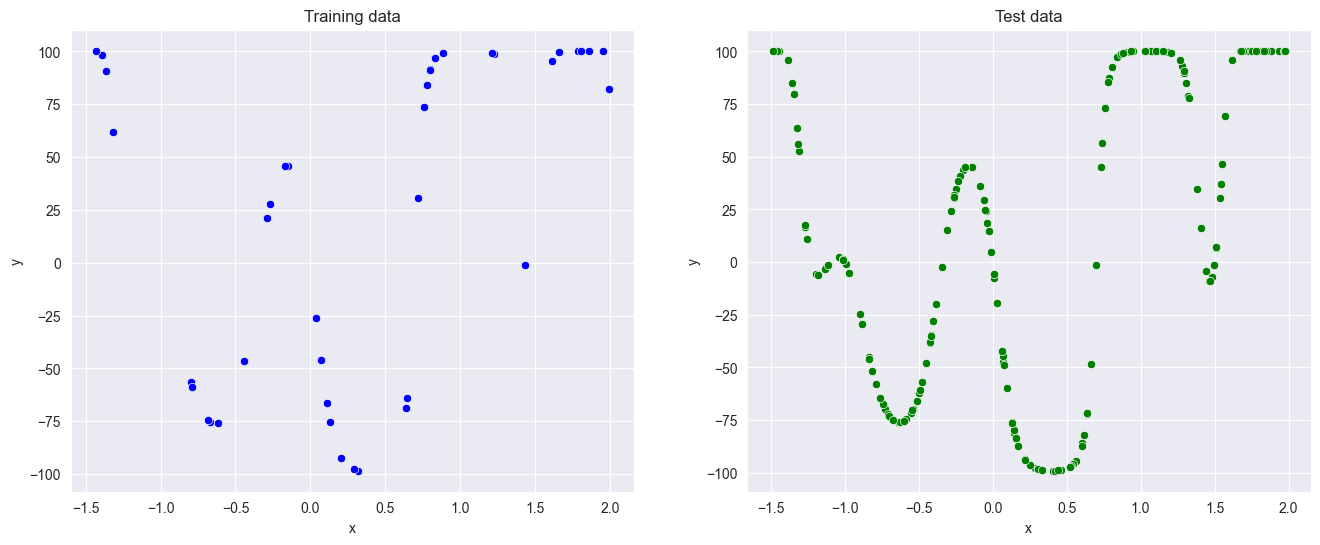

In [8]:
multimodal_sparse = RegressionDataset('multimodal-sparse')
multimodal_sparse.plot_dataset()

In [9]:
multimodal_sparse_train, multimodal_sparse_test = multimodal_sparse.to_df()

X_train, y_train = multimodal_sparse_train['x'].values.reshape(-1, 1), multimodal_sparse_train['y'].values.reshape(-1, 1)
X_test, y_test = multimodal_sparse_test['x'].values.reshape(-1, 1), multimodal_sparse_test['y'].values.reshape(-1, 1)

# let's scale the data for easier training
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### No regularization

In [35]:
set_seed(123)

In [36]:
model = nn.Sequential([
    nn.Linear(1, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
])
model.init_weights('xavier_uniform')

In [37]:
optimizer = nn.optimizers.Adam(model.parameters, lr=1e-3, )
criterion = nn.MSELoss()
trainer = nn.Trainer(model, optimizer, criterion)

In [ ]:
trainer.train(X_train_scaled, y_train_scaled, X_valid=X_test_scaled, y_valid=y_test_scaled, num_epochs=70000, batch_size=4, log_every=100)

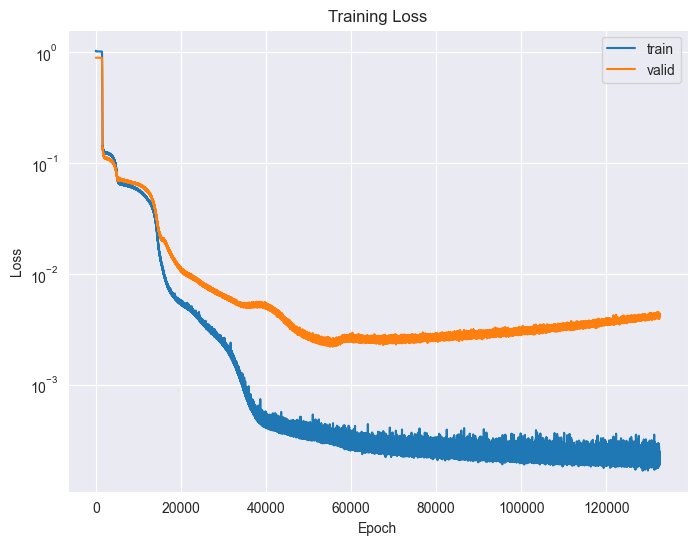

In [49]:
trainer.plot_training(ylog=True)

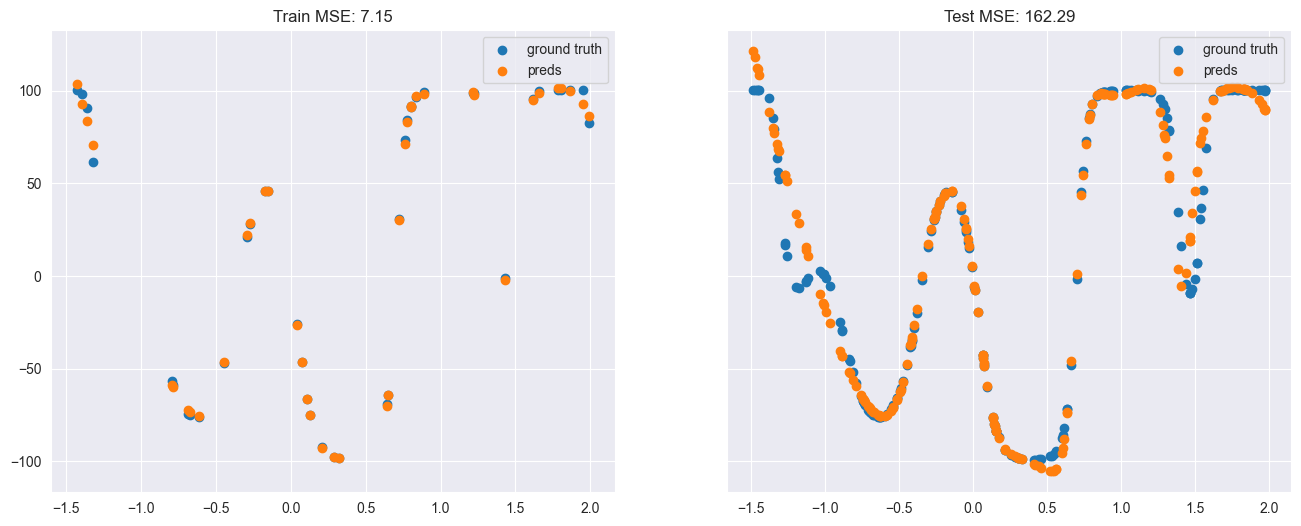

In [50]:
plot_preds_regression(model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler)

In [51]:
evaluate_regression(model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler)

Training MSE: 7.15
Test MSE: 162.29
----------


### Early stopping

In [81]:
set_seed(123)

In [82]:
model = nn.Sequential([
    nn.Linear(1, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
])
model.init_weights('xavier_uniform')

In [83]:
optimizer = nn.optimizers.Adam(model.parameters, lr=1e-3, )
criterion = nn.MSELoss()
early_stopping = nn.EarlyStopping(patience=7000)
trainer = nn.Trainer(model, optimizer, criterion, early_stopping)

In [ ]:
trainer.train(X_train_scaled, y_train_scaled, X_valid=X_test_scaled, y_valid=y_test_scaled, num_epochs=70000, batch_size=4, log_every=100)

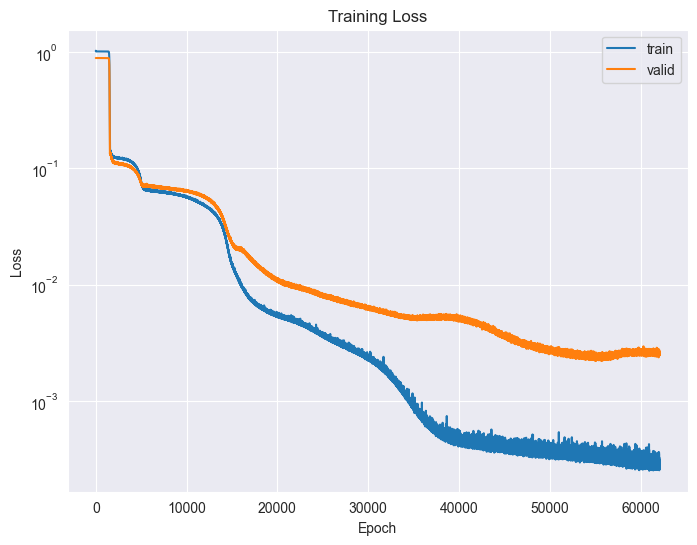

In [85]:
trainer.plot_training(ylog=True)

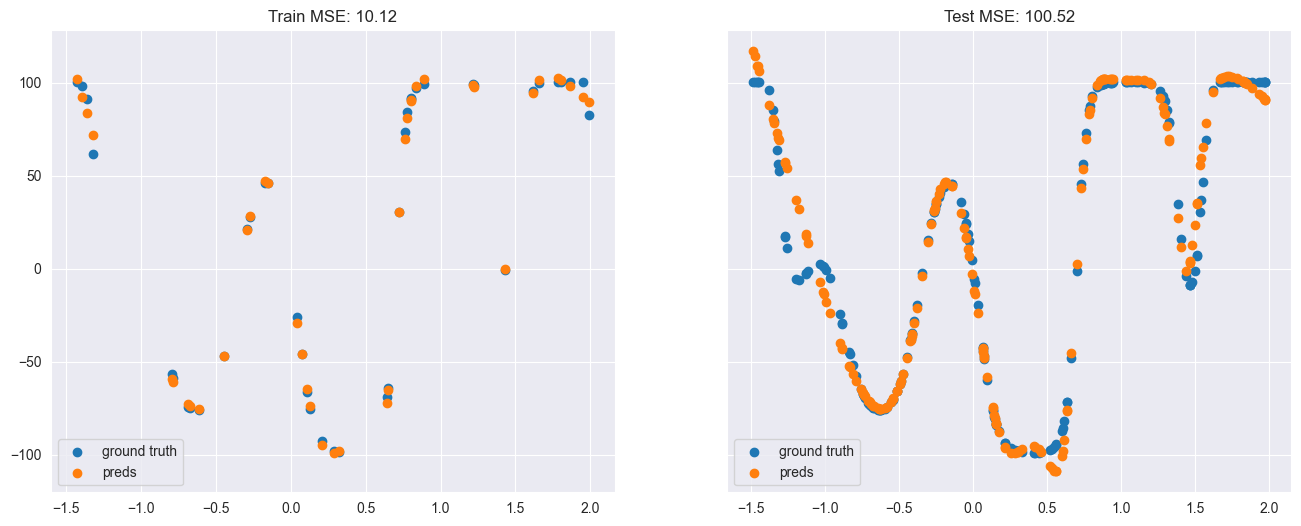

In [86]:
plot_preds_regression(model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler)

In [87]:
evaluate_regression(model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler)

Training MSE: 10.12
Test MSE: 100.52
----------


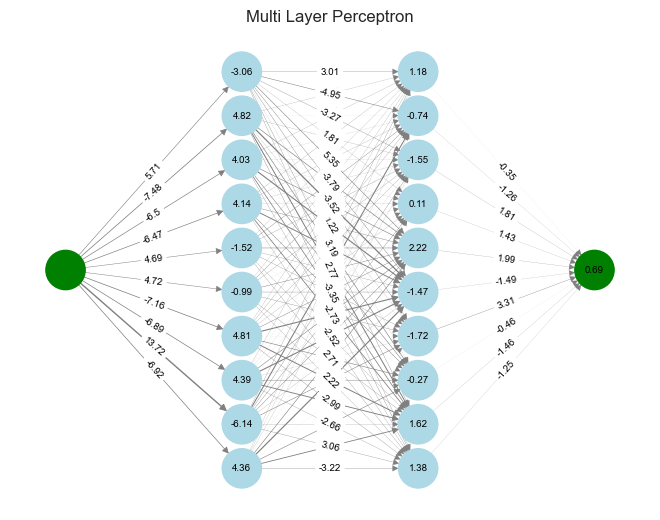

In [88]:
visualize_nn(model)

### Early stopping + L2 regularization

In [112]:
set_seed(123)

In [113]:
model = nn.Sequential([
    nn.Linear(1, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
])
model.init_weights('xavier_uniform')

In [114]:
optimizer = nn.optimizers.Adam(model.parameters, lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
early_stopping = nn.EarlyStopping(patience=7000)
trainer = nn.Trainer(model, optimizer, criterion, early_stopping)

In [ ]:
trainer.train(X_train_scaled, y_train_scaled, X_valid=X_test_scaled, y_valid=y_test_scaled, num_epochs=50000, batch_size=4, log_every=100)

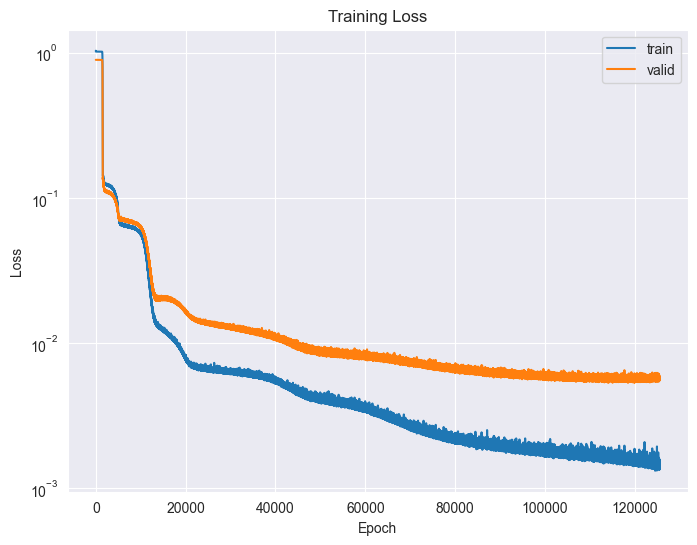

In [126]:
trainer.plot_training(ylog=True)

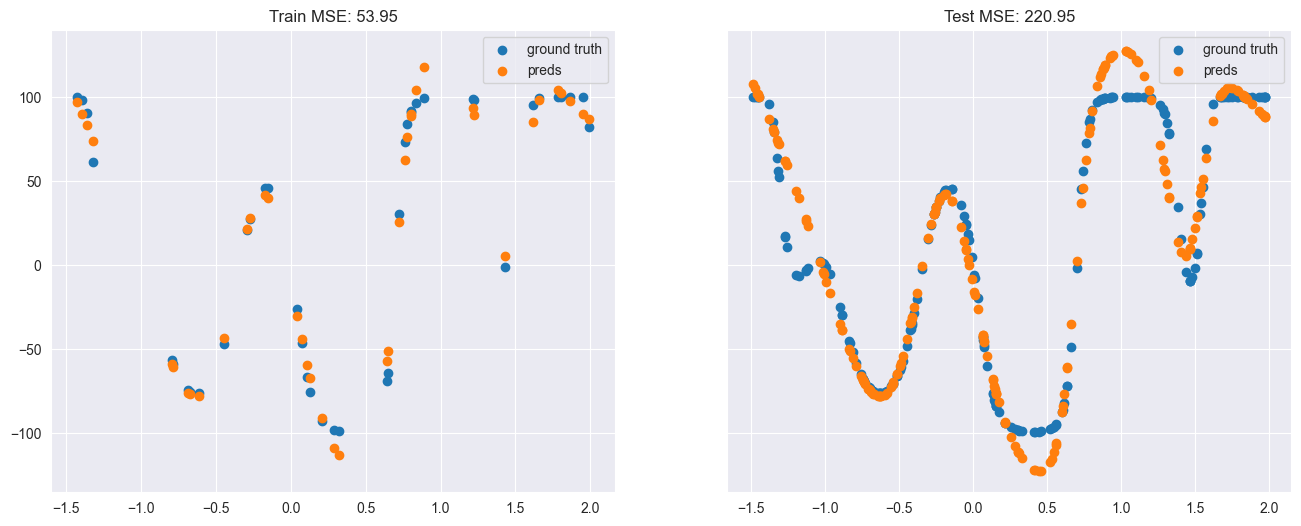

In [127]:
plot_preds_regression(model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler)

In [128]:
evaluate_regression(model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_scaler, y_scaler)

Training MSE: 53.95
Test MSE: 220.95
----------


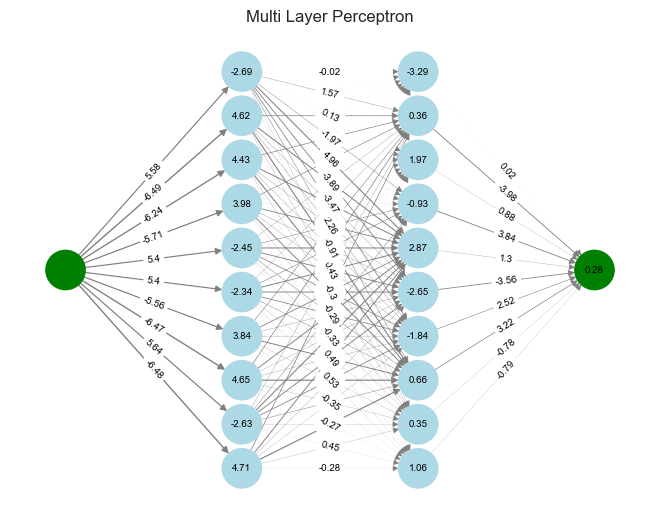

In [129]:
visualize_nn(model)

## rings3-balance

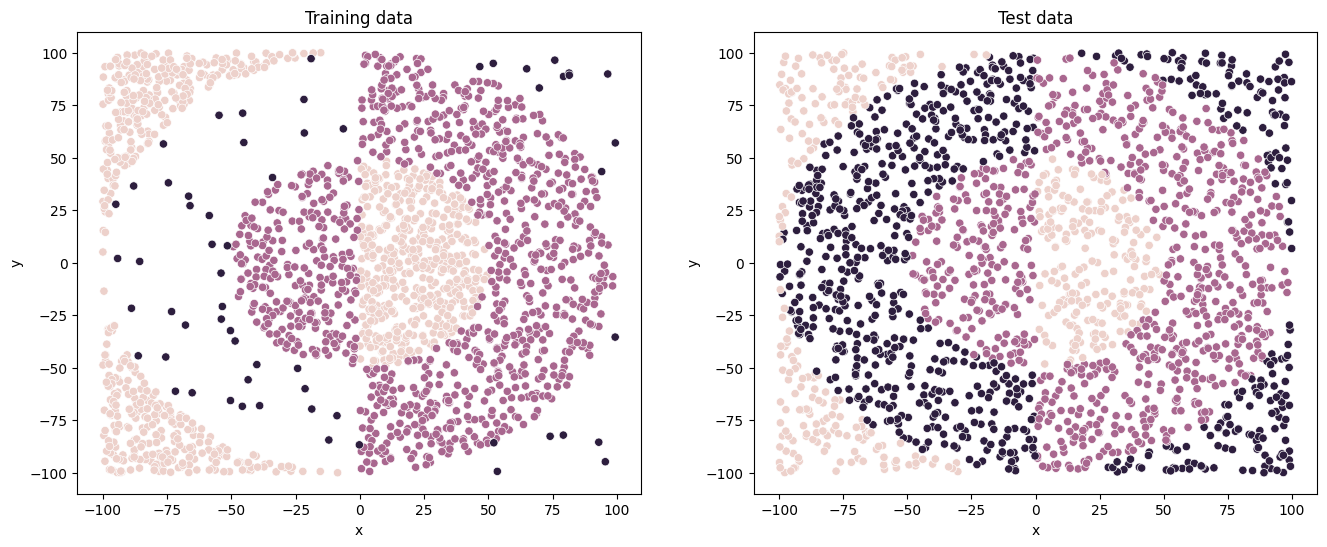

In [7]:
rings3_balance = ClassificationDataset('rings3-balance')
rings3_balance.plot_dataset()

In [8]:
rings3_balance_train, rings3_balance_test = rings3_balance.to_df()

X_train, y_train = rings3_balance_train[['x', 'y']].values, rings3_balance_train['c'].values.reshape(-1, 1)
X_test, y_test = rings3_balance_test[['x', 'y']].values, rings3_balance_test['c'].values.reshape(-1, 1)
# let's scale the data for easier training
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.squeeze())
y_test_encoded = encoder.transform(y_test.squeeze())

### No regularization

In [ ]:
model = nn.Sequential([
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10,10),
    nn.Tanh(),
    nn.Linear(10,10),
    nn.Tanh(),
    nn.Linear(10, 3),
])
model.init_weights('xavier_uniform')

In [23]:
optimizer = nn.optimizers.Adam(model.parameters, lr=1e-3, )
criterion = nn.CrossEntropyLoss()
trainer = nn.Trainer(model, optimizer, criterion)

In [ ]:
trainer.train(X_train_scaled, y_train_encoded, X_valid=X_test_scaled, y_valid=y_test_encoded, num_epochs=10000, batch_size=32, log_every=100)

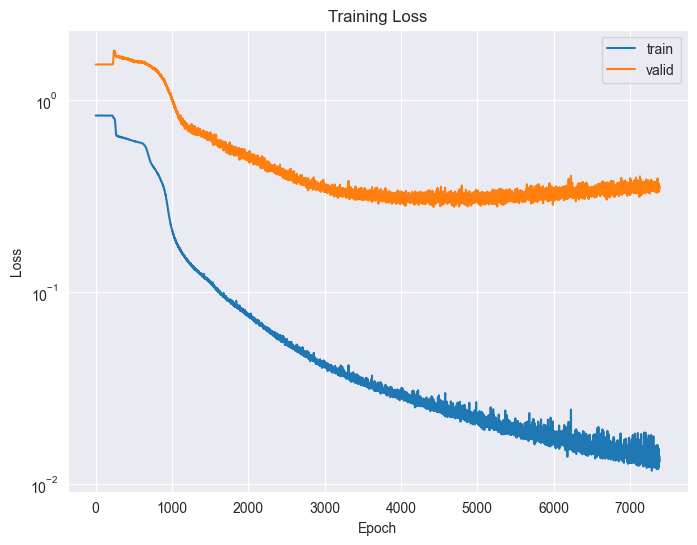

In [30]:
trainer.plot_training(ylog=True)

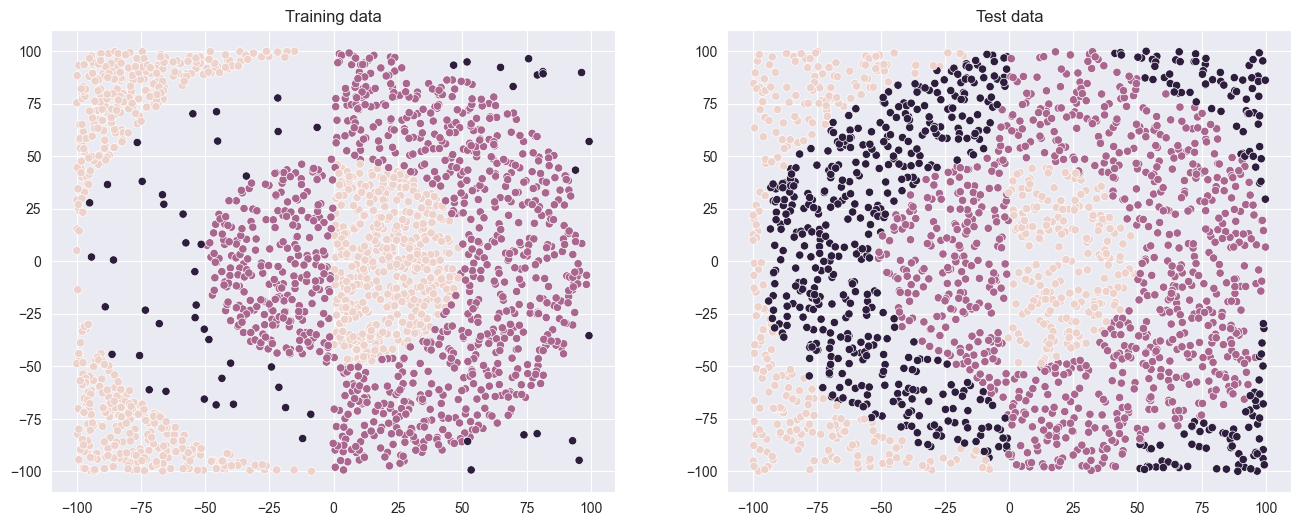

In [ ]:
plot_preds_classification(model, X_train_scaled, X_test_scaled, scaler)

In [32]:
evaluate_classification(model, X_train_scaled, y_train, X_test_scaled, y_test)

Training accuracy: 1.00
Test accuracy: 0.92
----------
Training F1-score: 0.99
Test F1-score: 0.92


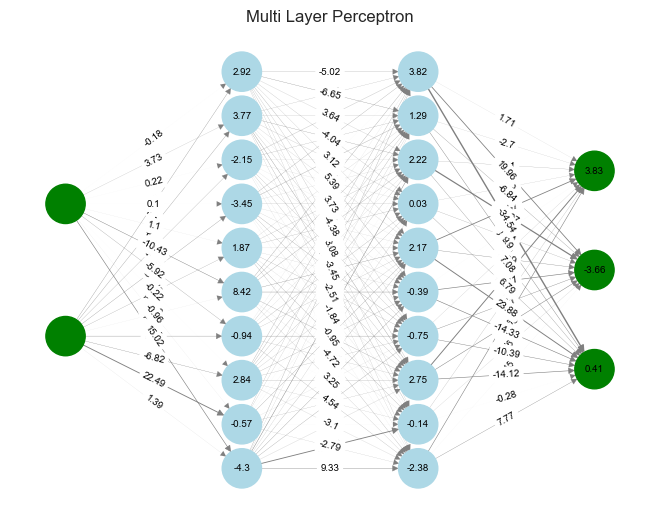

In [167]:
visualize_nn(model)

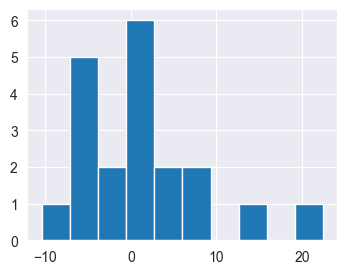

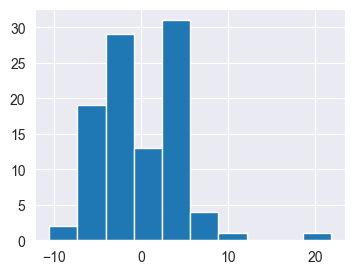

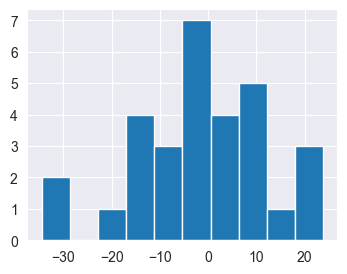

In [183]:
for param in model.parameters:
    plt.figure(figsize=(4, 3))
    plt.hist(param.weights.ravel())
    plt.show()

### Early stopping + L2 regularization

In [37]:
model = nn.Sequential([
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10,10),
    nn.Sigmoid(),
    nn.Linear(10, 3),
])
model.init_weights('xavier_uniform')

In [38]:
optimizer = nn.optimizers.Adam(model.parameters, lr=1e-3, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()
early_stopping = nn.EarlyStopping(patience=2000)
trainer = nn.Trainer(model, optimizer, criterion, early_stopping)

In [ ]:
trainer.train(X_train_scaled, y_train_encoded, X_valid=X_test_scaled, y_valid=y_test_encoded, num_epochs=10000, batch_size=32, log_every=100)

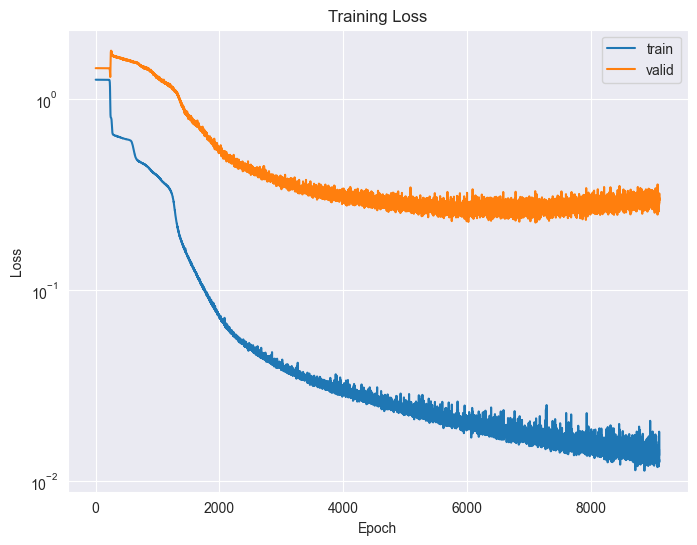

In [42]:
trainer.plot_training(ylog=True)

In [ ]:
plot_preds_classification(model, X_train_scaled, X_test_scaled, scaler)

In [44]:
evaluate_classification(model, X_train_scaled, y_train, X_test_scaled, y_test)

Training accuracy: 1.00
Test accuracy: 0.93
----------
Training F1-score: 0.99
Test F1-score: 0.93


In [166]:
from miowad.nn.viz import visualize_nn

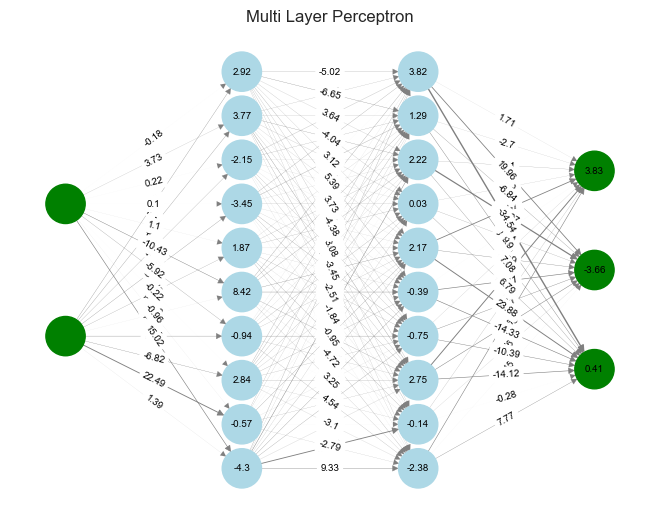

In [167]:
visualize_nn(model)

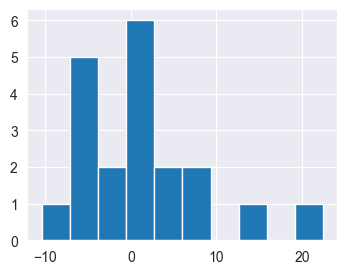

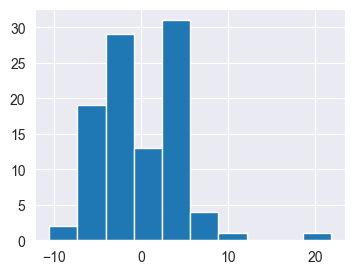

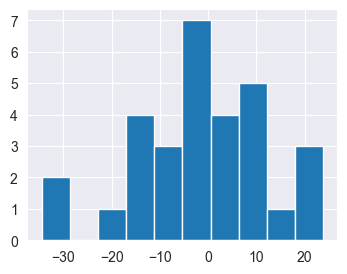

In [183]:
for param in model.parameters:
    plt.figure(figsize=(4, 3))
    plt.hist(param.weights.ravel())
    plt.show()

## xor3-balance

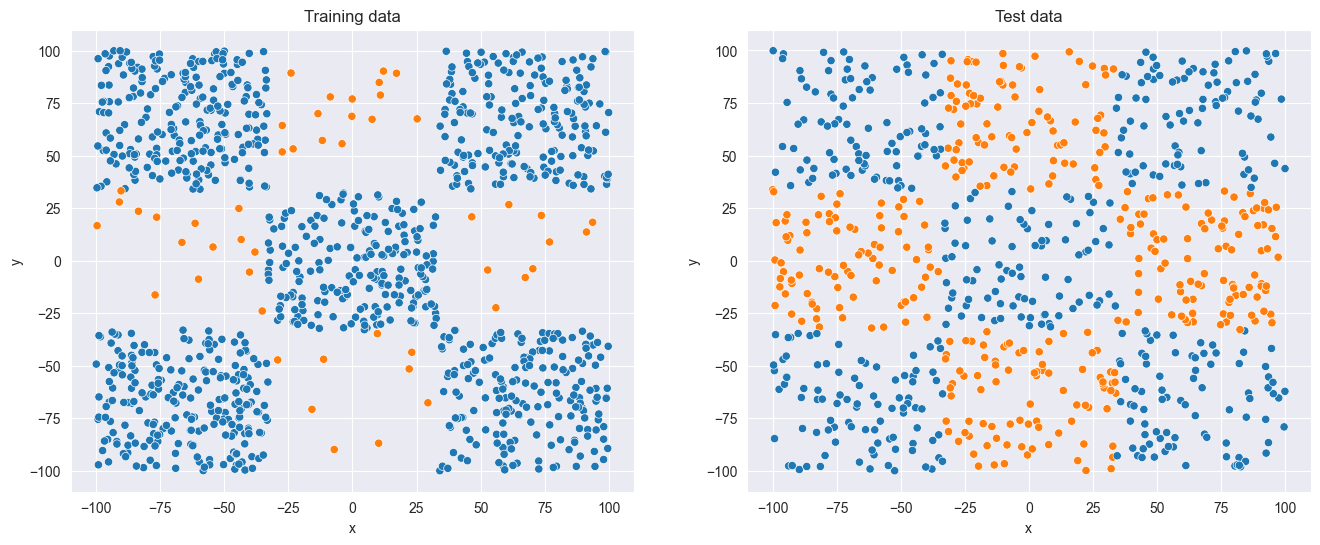

In [130]:
xor3_balance = ClassificationDataset('xor3-balance')
xor3_balance.plot_dataset()

In [131]:
xor3_balance_train, xor3_balance_test = xor3_balance.to_df()

X_train, y_train = xor3_balance_train[['x', 'y']].values, xor3_balance_train['c'].values.reshape(-1, 1)
X_test, y_test = xor3_balance_test[['x', 'y']].values, xor3_balance_test['c'].values.reshape(-1, 1)
# let's scale the data for easier training
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.squeeze())
y_test_encoded = encoder.transform(y_test.squeeze())

### No regularization

In [208]:
set_seed(42)
model = nn.Sequential([
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(100,100),
    nn.Sigmoid(),
    nn.Linear(10, 2),
])
model.init_weights('xavier_uniform')

In [209]:
optimizer = nn.optimizers.Adam(model.parameters, lr=1e-3, )
criterion = nn.CrossEntropyLoss()
trainer = nn.Trainer(model, optimizer, criterion)

In [ ]:
trainer.train(X_train_scaled, y_train_encoded, X_valid=X_test_scaled, y_valid=y_test_encoded, num_epochs=10000, batch_size=64, log_every=100)

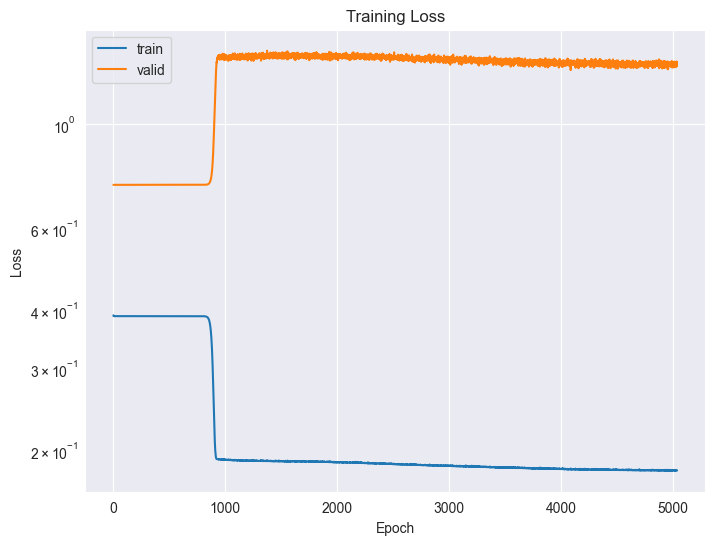

In [203]:
trainer.plot_training(ylog=True)

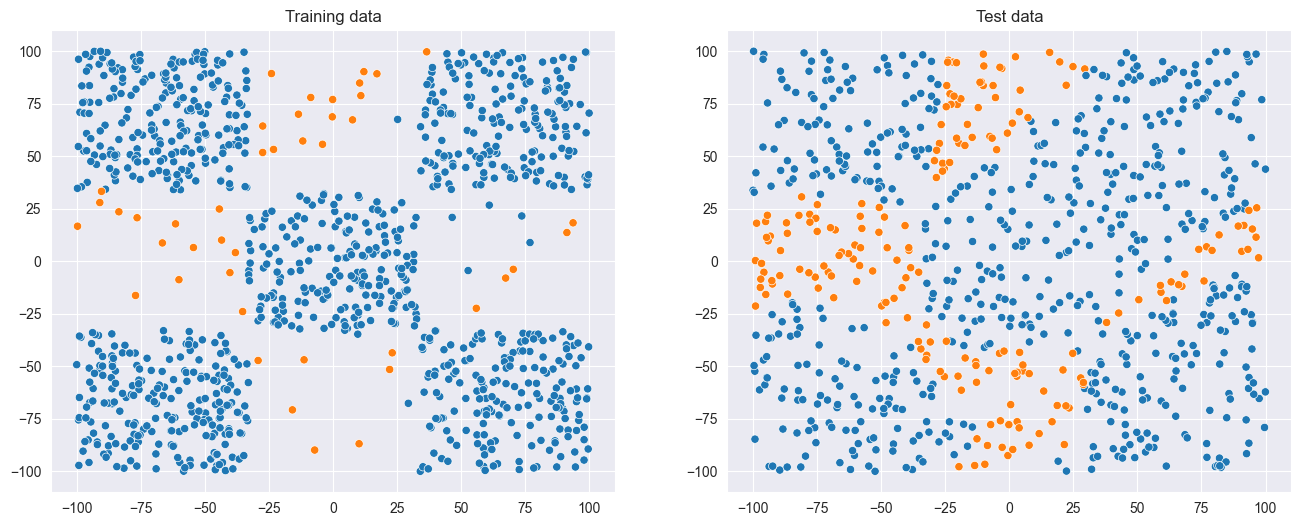

In [164]:
plot_preds_classification(model, X_train_scaled, X_test_scaled, scaler)

In [32]:
evaluate_classification(model, X_train_scaled, y_train, X_test_scaled, y_test)

Training accuracy: 1.00
Test accuracy: 0.92
----------
Training F1-score: 0.99
Test F1-score: 0.92


### Early stopping + L2 regularization

In [310]:
set_seed(123)
model = nn.Sequential([
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10, 2),
])
model.init_weights('xavier_normal')

In [311]:
optimizer = nn.optimizers.Adam(model.parameters, lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
early_stopping = nn.EarlyStopping(patience=2000)
trainer = nn.Trainer(model, optimizer, criterion, early_stopping)

In [ ]:
trainer.train(X_train_scaled, y_train_encoded, X_valid=X_test_scaled, y_valid=y_test_encoded, num_epochs=10000, batch_size=16, log_every=100)

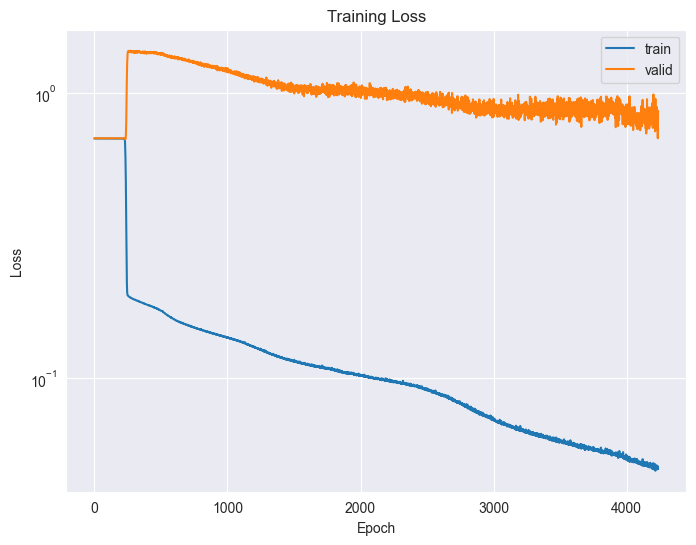

In [324]:
trainer.plot_training(ylog=True)

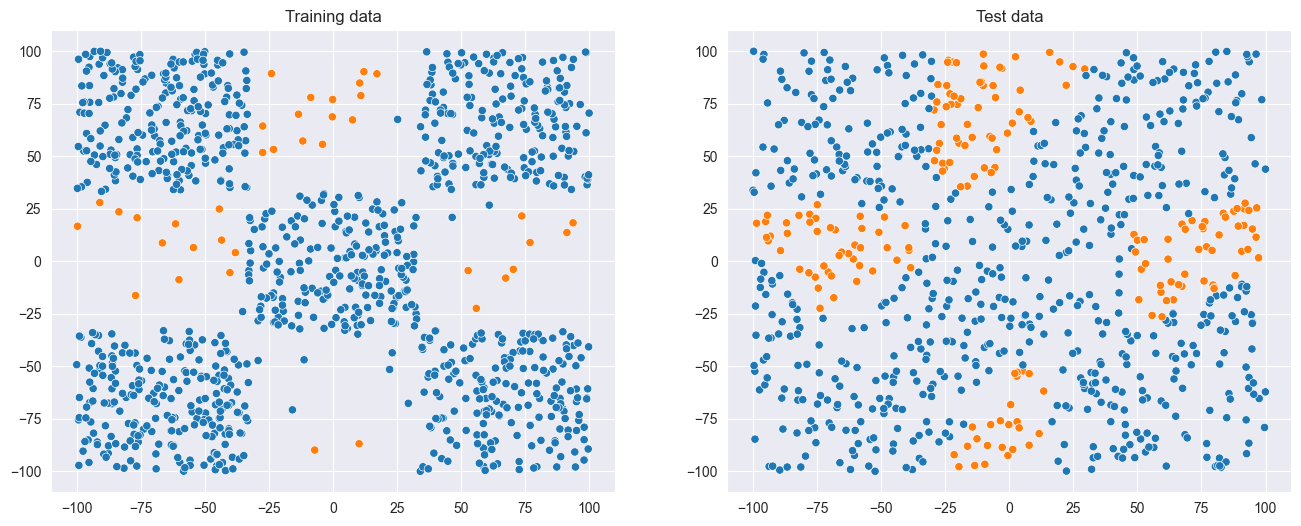

In [325]:
plot_preds_classification(model, X_train_scaled, X_test_scaled, scaler)

In [326]:
evaluate_classification(model, X_train_scaled, y_train, X_test_scaled, y_test)

Training accuracy: 0.99
Test accuracy: 0.78
----------
Training F1-score: 0.93
Test F1-score: 0.75
